# Hahackathon

[CodaLab Contest](https://competitions.codalab.org/competitions/27446#learn_the_details-overview)

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Spring 2021/EE 460J/DS Lab Final Project/Data/train.csv')
train.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1


In [4]:
test = pd.read_csv('/content/drive/MyDrive/Spring 2021/EE 460J/DS Lab Final Project/Data/public_test.csv')
test.head()

,id,text
0,9001,Finding out your ex got fat is like finding 20...
1,9002,"For Brockmann, stereotypes imperil national se..."
2,9003,A girl runs up to her mother with a pile of cr...
3,9004,gotta wonder if baseball still would've been c...
4,9005,When you're dreading getting in the shower cuz...


# EDA

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 8000 non-null   int64  
 1   text               8000 non-null   object 
 2   is_humor           8000 non-null   int64  
 3   humor_rating       4932 non-null   float64
 4   humor_controversy  4932 non-null   float64
 5   offense_rating     8000 non-null   float64
dtypes: float64(3), int64(2), object(1)
memory usage: 375.1+ KB


In [ ]:
sum(train.is_humor)

4932

It looks like there are no missing values. We can see that for all texts that are classified as humorous, there are corresponding humor ratings and humor controversies.

Let's look at some [wordclouds](https://www.datacamp.com/community/tutorials/wordcloud-python) now.

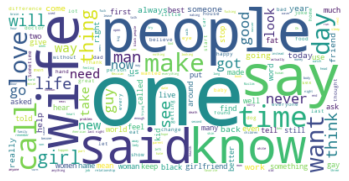

In [ ]:
all_text = ' '.join(text for text in train.text)
#print(all_text)

stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Now let's look at a word cloud of only texts classified as humorous.

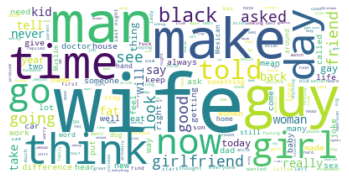

In [ ]:
humor_text = ' '.join(text for text in train.loc[train.is_humor == 1].text)
#print(humor_text)

stopwords.update(["say", "people", "one", "said", "want", "call", "know", "got"])

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(humor_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Let's look at a wordcloud made from text's that are considered controversial in terms of humor.

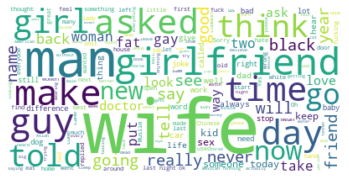

In [ ]:
humor_text = ' '.join(text for text in train.loc[train.humor_controversy == 1].text)
#print(humor_text)

stopwords.update(["say", "people", "one", "said", "want", "call", "know", "got"])

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(humor_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

It looks like several texts refer to women, as we can see the words "wife", "girl", and "girlfriend". Let's see how this compares to offensive texts. First we'll look at the distribution of offensive ratings.

(array([5629.,  704.,  447.,  317.,  264.,  224.,  145.,  155.,   88.,
          27.]),
 array([0.   , 0.485, 0.97 , 1.455, 1.94 , 2.425, 2.91 , 3.395, 3.88 ,
        4.365, 4.85 ]),
 <a list of 10 Patch objects>)

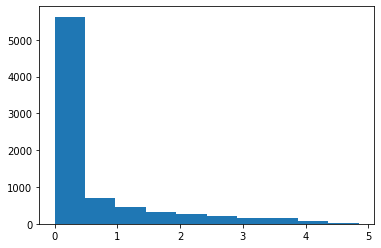

In [ ]:
plt.hist(train.offense_rating)

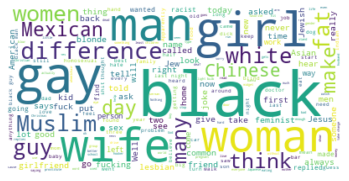

In [ ]:
offensive_text = ' '.join(text for text in train.loc[train.offense_rating > 1].text)
#print(offensive_text)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(offensive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We can already see why many of these texts were classified as offensive. Several of the words refer to either a person's race or ethnicity, and we can also see gendered words such as "wife", "woman", and "girl" again. The competition defines offensive text to be anything that "targets a person or group simply for belonging to a specific group" and "that a significant number of people would find this offensive".

# Text Preprocessing

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer, sent_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
X = train.text
y = train.is_humor
#y = train.offense_rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [ ]:
# selecting only those that are humorous
X = train.loc[pd.notnull(train['humor_controversy'])].text
y = train.loc[pd.notnull(train['humor_controversy'])].humor_controversy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

## Tokenizers

https://www.programcreek.com/python/example/99488/nltk.tokenize.treebank.TreebankWordTokenizer

In [7]:
_treebank_word_tokenizer = TreebankWordTokenizer()

def word_tokenize(text, language='english'):
    """
    Return a tokenized copy of *text*,
    using NLTK's recommended word tokenizer
    (currently an improved :class:`.TreebankWordTokenizer`
    along with :class:`.PunktSentenceTokenizer`
    for the specified language).

    :param text: text to split into words
    :type text: str
    :param language: the model name in the Punkt corpus
    :type language: str
    """
    sentences = sent_tokenize(text, language)
    return [
        token for sent in sentences for token in _treebank_word_tokenizer.tokenize(sent)
    ] 

## Count Vectorizer

In [ ]:
stopwords_preprocessed = []
for word in stopwords.words('english'):
  stopwords_preprocessed.extend(word_tokenize(word))

print(stopwords_preprocessed)
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'you', "'re", 'you', "'ve", 'you', "'ll", 'you', "'d", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'she', "'s", 'her', 'hers', 'herself', 'it', 'it', "'s", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'that', "'ll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'o

In [8]:
vectorizer = CountVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize)
count_vec_train = vectorizer.fit_transform(X_train)
count_vec_test = vectorizer.transform(X_test)
#print(np.shape(count_vec_train.toarray()))
#count_vec_train.toarray()

## Tfidf Vectorizer

In [10]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize)
tfidf_vec_train = vectorizer.fit_transform(X_train)
tfidf_vec_test = vectorizer.transform(X_test)
#print(np.shape(tfidf_vec_train.toarray()))
#tfidf_vec_train.toarray()

## Doc2Vec

https://towardsdatascience.com/how-to-vectorize-text-in-dataframes-for-nlp-tasks-3-simple-techniques-82925a5600db

In [ ]:
#tokenize and tag the card text
text_docs = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(train.text)]
#display the tagged docs
#text_docs

#instantiate model
model = Doc2Vec(vector_size = 64, min_count = 1, epochs = 20)

#build vocab
model.build_vocab(text_docs)
#train model
model.train(text_docs, total_examples=model.corpus_count, epochs=model.epochs)
#generate vectors
text2vec = [model.infer_vector((train['text'][i].split(' '))) 
            for i in range(0, len(train['text']))]

In [ ]:
print(text2vec[0])
np.shape(text2vec)

[-0.27151546  0.12537679  0.01187428  0.04303377  0.04050291 -0.14512007
  0.20451799 -0.02715521 -0.15348256  0.04729481  0.20829612  0.02672263
  0.01825381 -0.10519914 -0.14171991 -0.08224774  0.2517955   0.02733728
  0.10940784 -0.18918987 -0.1771483   0.10713628  0.04585102  0.05717394
 -0.06106758 -0.04321318  0.04200377  0.00332398  0.04496183 -0.02391031
 -0.01990202 -0.04286801  0.07700919 -0.03745062  0.01999247  0.05162936
 -0.14878117  0.13674939  0.0373187   0.16895445  0.03568981  0.01033816
 -0.04204187 -0.17632207 -0.03053015  0.09789781  0.10811044 -0.14792454
  0.00886672 -0.11958601  0.01255899  0.15442964 -0.04461575  0.08468045
  0.04330771  0.00633809  0.02278954  0.15563759  0.00142331 -0.04978889
 -0.04626855 -0.17516197 -0.00718288 -0.19007272]


(8000, 64)

In [ ]:
# add vectors to dataframe
#Create a list of lists
dtv= np.array(text2vec).tolist()

#set list to dataframe column
train['text2vec'] = dtv

train.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating,text2vec
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2,"[-0.27151545882225037, 0.12537679076194763, 0...."
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1,"[-0.4633568525314331, 0.034762777388095856, 0...."
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4,"[-0.24787798523902893, -0.09043152630329132, 0..."
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0,"[-0.3316991925239563, 0.33572879433631897, 0.1..."
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1,"[-0.3573562204837799, -0.18014860153198242, -0..."


In [ ]:
X = text2vec #train.text2vec
y = train.is_humor
#y = train.offense_rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Is Humor - Base Models

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import roc_auc_score, f1_score
from lightgbm import LGBMClassifier

## Logistic Regression

In [12]:
log = LogisticRegression(max_iter=500, 
                         class_weight = 'balanced', 
                         random_state=42).fit(count_vec_train, y_train)

print(f"AUC: {roc_auc_score(y_test, log.predict_proba(count_vec_test)[:, 1])}")
print(f"Accuracy: {log.score(count_vec_test, y_test)}")
print(f"F1 score: {f1_score(y_test, log.predict(count_vec_test))}")

AUC: 0.940591787554549
Accuracy: 0.8755
F1 score: 0.8987393249288329


In [13]:
log = LogisticRegression(max_iter=200, class_weight = 'balanced', random_state=42).fit(tfidf_vec_train.toarray(), y_train)

print(f"AUC: {roc_auc_score(y_test, log.predict_proba(tfidf_vec_test.toarray())[:, 1])}")
print(f"Accuracy: {log.score(tfidf_vec_test.toarray(), y_test)}")
print(f"F1 score: {f1_score(y_test, log.predict(tfidf_vec_test.toarray()))}")

AUC: 0.9346544557481091
Accuracy: 0.868
F1 score: 0.8900915903413822


## Complement Naive Bayes

In [14]:
cnb = ComplementNB(alpha=0.19).fit(count_vec_train, y_train)

print(f"AUC: {roc_auc_score(y_test, cnb.predict_proba(count_vec_test)[:, 1])}")
print(f"Accuracy: {cnb.score(count_vec_test, y_test)}")
print(f"F1 score: {f1_score(y_test, cnb.predict(count_vec_test))}")

AUC: 0.9453384807832415
Accuracy: 0.882
F1 score: 0.9056


In [ ]:
# creating submission
vectorizer = CountVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize)
count_vec_train = vectorizer.fit_transform(X)
count_vec_test = vectorizer.transform(test.text)

cnb = ComplementNB(alpha=0.2).fit(count_vec_train, y) # fit on all training data

submission = pd.DataFrame({'id': test.id, 'is_humor': cnb.predict(count_vec_test)})
submission.to_csv('satya_orig_submission.csv', index = False)
submission.head()

,id,is_humor
0,9001,1
1,9002,0
2,9003,1
3,9004,1
4,9005,1


In [15]:
cnb = ComplementNB(alpha=0.2).fit(tfidf_vec_train.toarray(), y_train)

print(f"AUC: {roc_auc_score(y_test, cnb.predict_proba(tfidf_vec_test.toarray())[:, 1])}")
print(f"Accuracy: {cnb.score(tfidf_vec_test.toarray(), y_test)}")
print(f"F1 score: {f1_score(y_test, cnb.predict(tfidf_vec_test.toarray()))}")

AUC: 0.9504922751242187
Accuracy: 0.8695
F1 score: 0.8990328820116055


## Multinomial Naive Bayes

In [16]:
mnb = MultinomialNB(alpha=0.12).fit(count_vec_train, y_train)

print(f"AUC: {roc_auc_score(y_test, mnb.predict_proba(count_vec_test)[:, 1])}")
print(f"Accuracy: {mnb.score(count_vec_test, y_test)}")
print(f"F1 score: {f1_score(y_test, mnb.predict(count_vec_test))}")

AUC: 0.9448404427991215
Accuracy: 0.8815
F1 score: 0.9056904098686829


In [ ]:
# creating submission
vectorizer = CountVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize)
count_vec_train = vectorizer.fit_transform(X)
count_vec_test = vectorizer.transform(test.text)

mnb = MultinomialNB(alpha=0.12).fit(count_vec_train, y) # fit on all training data

submission = pd.DataFrame({'id': test.id, 'is_humor': mnb.predict(count_vec_test)})
submission.to_csv('satya_multinomial.csv', index = False)
submission.head()

,id,is_humor
0,9001,1
1,9002,0
2,9003,1
3,9004,1
4,9005,1


In [17]:
mnb = MultinomialNB(alpha=0.2).fit(tfidf_vec_train.toarray(), y_train)

print(f"AUC: {roc_auc_score(y_test, mnb.predict_proba(tfidf_vec_test.toarray())[:, 1])}")
print(f"Accuracy: {mnb.score(tfidf_vec_test.toarray(), y_test)}")
print(f"F1 score: {f1_score(y_test, mnb.predict(tfidf_vec_test.toarray()))}")

AUC: 0.9504922751242187
Accuracy: 0.8575
F1 score: 0.8937756243011554


## Random Forest

In [18]:
rf = RandomForestClassifier(random_state=42).fit(count_vec_train, y_train)

print(f"AUC: {roc_auc_score(y_test, rf.predict_proba(count_vec_test)[:, 1])}")
print(f"Accuracy: {rf.score(count_vec_test, y_test)}")
print(f"F1 score: {f1_score(y_test, rf.predict(count_vec_test))}")

AUC: 0.9353586878020875
Accuracy: 0.867
F1 score: 0.8945281522601111


In [19]:
rf = RandomForestClassifier(random_state=42).fit(tfidf_vec_train, y_train)

print(f"AUC: {roc_auc_score(y_test, rf.predict_proba(tfidf_vec_test)[:, 1])}")
print(f"Accuracy: {rf.score(tfidf_vec_test, y_test)}")
print(f"F1 score: {f1_score(y_test, rf.predict(tfidf_vec_test))}")

AUC: 0.9289751308803641
Accuracy: 0.86
F1 score: 0.889937106918239


## AdaBoost

In [20]:
adb = AdaBoostClassifier(random_state=42).fit(count_vec_train, y_train)

print(f"AUC: {roc_auc_score(y_test, adb.predict_proba(count_vec_test)[:, 1])}")
print(f"Accuracy: {adb.score(count_vec_test, y_test)}")
print(f"F1 score: {f1_score(y_test, adb.predict(count_vec_test))}")

AUC: 0.9048266330834683
Accuracy: 0.8345
F1 score: 0.8650631879331432


In [21]:
adb = AdaBoostClassifier(random_state=42).fit(tfidf_vec_train, y_train)

print(f"AUC: {roc_auc_score(y_test, adb.predict_proba(tfidf_vec_test)[:, 1])}")
print(f"Accuracy: {adb.score(tfidf_vec_test, y_test)}")
print(f"F1 score: {f1_score(y_test, adb.predict(tfidf_vec_test))}")

AUC: 0.8866112374710666
Accuracy: 0.8085
F1 score: 0.8452525252525253


In [ ]:
# using doc2vec
adb = AdaBoostClassifier(random_state=42).fit(X_train, y_train)

print(f"AUC: {roc_auc_score(y_test, adb.predict_proba(X_test)[:, 1])}")
print(f"Accuracy: {adb.score(X_test, y_test)}")
print(f"F1 score: {f1_score(y_test, adb.predict(X_test))}")

AUC: 0.837566650828846
Accuracy: 0.7725
F1 score: 0.8237572627501614


## LightGBM

In [ ]:
# using doc2vec
lgbm = LGBMClassifier().fit(X_train, y_train)

print(f"AUC: {roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1])}")
print(f"Accuracy: {lgbm.score(X_test, y_test)}")
print(f"F1 score: {f1_score(y_test, lgbm.predict(X_test))}")

AUC: 0.8722459789532959
Accuracy: 0.7945833333333333
F1 score: 0.8380952380952381


## SVC

In [22]:
svc = LinearSVC(penalty='l1', dual=False, max_iter=2000, random_state=42).fit(count_vec_train, y_train)

#print(f"AUC: {roc_auc_score(y_test, svc.predict_proba(count_vec_test.toarray())[:, 1])}")
print(f"Accuracy: {svc.score(count_vec_test, y_test)}")
print(f"F1 score: {f1_score(y_test, svc.predict(count_vec_test))}")

Accuracy: 0.85
F1 score: 0.8795180722891566


In [23]:
svc = SVC(random_state=42).fit(count_vec_train, y_train)

#print(f"AUC: {roc_auc_score(y_test, svc.predict_proba(count_vec_test.toarray())[:, 1])}")
print(f"Accuracy: {svc.score(count_vec_test, y_test)}")
print(f"F1 score: {f1_score(y_test, svc.predict(count_vec_test))}")

Accuracy: 0.8745
F1 score: 0.8995598239295718


In [24]:
svc = SVC(kernel='sigmoid', gamma = 1.0, random_state=42).fit(tfidf_vec_train, y_train)

#print(f"AUC: {roc_auc_score(y_test, svc.predict_proba(count_vec_test.toarray())[:, 1])}")
print(f"Accuracy: {svc.score(tfidf_vec_test, y_test)}")
print(f"F1 score: {f1_score(y_test, svc.predict(tfidf_vec_test))}")

Accuracy: 0.8825
F1 score: 0.9060375849660136


In [ ]:
# creating submission
vectorizer = TfidfVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize)
tfidf_vec_train = vectorizer.fit_transform(X)
tfidf_vec_test = vectorizer.transform(test.text)

svc = SVC(kernel='sigmoid', gamma = 1.0, random_state=42).fit(tfidf_vec_train, y) # fit on all training data

submission = pd.DataFrame({'id': test.id, 'is_humor': svc.predict(tfidf_vec_test)})
submission.to_csv('satya_svc.csv', index = False)
submission.head()

,id,is_humor
0,9001,1
1,9002,0
2,9003,1
3,9004,1
4,9005,1


## Stacking

In [ ]:
clf = StackingClassifier(estimators = [('cnb', cnb),
                                       ('svc', svc),
                                       ('rf', rf)],
                         final_estimator = log)

clf.fit(count_vec_train, y_train)

print(f"AUC: {roc_auc_score(y_test, clf.predict_proba(count_vec_test)[:, 1])}")
print(f"Accuracy: {clf.score(count_vec_test, y_test)}")
print(f"F1 score: {f1_score(y_test, clf.predict(count_vec_test))}")

AUC: 0.9498123633964286
Accuracy: 0.8955
F1 score: 0.9147982062780268


In [ ]:
# creating submission
vectorizer = CountVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize)
count_vec_train = vectorizer.fit_transform(X)
count_vec_test = vectorizer.transform(test.text)

clf = StackingClassifier(estimators = [('cnb', cnb),
                                       ('svc', svc),
                                       ('rf', rf)],
                         final_estimator = log).fit(count_vec_train, y) # fit on all training data

submission = pd.DataFrame({'id': test.id, 'is_humor': clf.predict(count_vec_test)})
submission.to_csv('satya_stack_submission_3.csv', index = False)
submission.head()

,id,is_humor
0,9001,1
1,9002,0
2,9003,1
3,9004,1
4,9005,1


# Is Humor with More Training Data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
import nltk
nltk.download('punkt')
from nltk.tokenize import TreebankWordTokenizer, sent_tokenize
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import roc_auc_score, f1_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
train_1 = pd.read_csv('/content/drive/MyDrive/Spring 2021/EE 460J/DS Lab Final Project/Data/train.csv')
train_1.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1


In [ ]:
train_2 = pd.read_csv('/content/drive/MyDrive/Spring 2021/EE 460J/DS Lab Final Project/Data/train_2.csv')
train_2.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


In [ ]:
train_2['is_humor'] = train_2['humor'].astype(int)
train_2.drop(['humor'], axis = 1, inplace=True)
train_2.head()

,text,is_humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",0
1,Watch: darvish gave hitter whiplash with slow ...,0
2,What do you call a turtle without its shell? d...,1
3,5 reasons the 2016 election feels so personal,0
4,"Pasco police shot mexican migrant from behind,...",0


In [ ]:
train_ishumor = train_1[['text', 'is_humor']]
train_total = pd.concat([train_ishumor, train_2])
print(np.shape(train_total))
train_total.head()

(208000, 2)


,text,is_humor
0,TENNESSEE: We're the best state. Nobody even c...,1
1,A man inserted an advertisement in the classif...,1
2,How many men does it take to open a can of bee...,1
3,Told my mom I hit 1200 Twitter followers. She ...,1
4,Roses are dead. Love is fake. Weddings are bas...,1


## Preprocessing

In [ ]:
# X = train_total.text
# y = train_total.is_humor

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
X_train = train_2.text
y_train = train_2.is_humor

X_test = train_1.text
y_test = train_1.is_humor

In [ ]:
_treebank_word_tokenizer = TreebankWordTokenizer()

def word_tokenize(text, language='english'):
    """
    Return a tokenized copy of *text*,
    using NLTK's recommended word tokenizer
    (currently an improved :class:`.TreebankWordTokenizer`
    along with :class:`.PunktSentenceTokenizer`
    for the specified language).

    :param text: text to split into words
    :type text: str
    :param language: the model name in the Punkt corpus
    :type language: str
    """
    sentences = sent_tokenize(text, language)
    return [
        token for sent in sentences for token in _treebank_word_tokenizer.tokenize(sent)
    ] 

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize)
count_vec_train = vectorizer.fit_transform(X_train)
count_vec_test = vectorizer.transform(X_test)
#print(np.shape(count_vec_train.toarray()))
#count_vec_train.toarray()

In [ ]:
count_vec_train

<156000x729382 sparse matrix of type '<class 'numpy.int64'>'
	with 4128167 stored elements in Compressed Sparse Row format>

## ComplementNB

In [ ]:
cnb = ComplementNB(alpha=0.2).fit(count_vec_train, y_train)

print(f"AUC: {roc_auc_score(y_test, cnb.predict_proba(count_vec_test)[:, 1])}")
print(f"Accuracy: {cnb.score(count_vec_test, y_test)}")
print(f"F1 score: {f1_score(y_test, cnb.predict(count_vec_test))}")

AUC: 0.8221847768504331
Accuracy: 0.71175
F1 score: 0.8055649241146712


## Creating submission

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Spring 2021/EE 460J/DS Lab Final Project/Data/public_test.csv')
test.head()

,id,text
0,9001,Finding out your ex got fat is like finding 20...
1,9002,"For Brockmann, stereotypes imperil national se..."
2,9003,A girl runs up to her mother with a pile of cr...
3,9004,gotta wonder if baseball still would've been c...
4,9005,When you're dreading getting in the shower cuz...


In [ ]:
count_vec_test = vectorizer.transform(test.text)

In [ ]:
submission = pd.DataFrame({'id': test.id, 'is_humor': cnb.predict(count_vec_test)})
submission.to_csv('satya_is_humor_200k.csv', index = False)
submission.head()

,id,is_humor
0,9001,1
1,9002,0
2,9003,1
3,9004,1
4,9005,1


# Is Humor - BERT

[Tensorflow Tutorial](https://www.tensorflow.org/tutorials/text/classify_text_with_bert#about_bert)

## Setup

In [ ]:
!pip install -q tensorflow-text

     |████████████████████████████████| 3.4MB 8.7MB/s 


In [ ]:
! pip install -q tf-models-official

     |████████████████████████████████| 1.1MB 8.5MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 37.6MB 93kB/s 
     |████████████████████████████████| 1.2MB 42.6MB/s 
     |████████████████████████████████| 706kB 40.7MB/s 
     |████████████████████████████████| 174kB 37.9MB/s 
     |████████████████████████████████| 358kB 45.5MB/s 
     |████████████████████████████████| 645kB 40.8MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Preprocessing

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
text_test = [train.text[0]]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 5298 1024 2057 1005 2128 1996 2190 2110 1012 6343 2130]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2",
    trainable=True) #hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.71777236  0.9859381   0.1632732   0.08053973  0.18662259 -0.2548545
  0.9908978  -0.9971226  -0.12554534 -0.9764338   0.04651375 -0.84267503]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.54523253 -0.8591926   1.1096289  ... -0.34218556 -0.03550489
  -0.15468165]
 [ 0.02320136 -0.92698634  0.5625397  ... -0.39456272 -0.40460137
  -1.3363492 ]
 [-0.19718897  0.24357179  1.4573593  ... -0.09528726 -0.280862
  -0.27212122]
 ...
 [-0.78139985 -0.64788073 -0.5539223  ... -1.376293   -0.5420343
  -0.08802697]
 [-0.84861416 -0.6612632   0.31138313 ... -0.67894036  0.3597949
  -0.6314106 ]
 [-1.5146255  -0.16258556  0.17368329 ... -1.2734061   1.3440248
   0.1021224 ]]


## Define the model

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='Input')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x7f0900732b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/tracking/tracking.py", line 208, in __del__
    self._destroy_resource()
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 726, in _initialize
    *args, **kwds))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/function.py", line 2969, in _get_concrete_function_internal_garbage_collected
    graph_function, _ = self._maybe_define_function(args, kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/p

tf.Tensor([[0.33742207]], shape=(1, 1), dtype=float32)


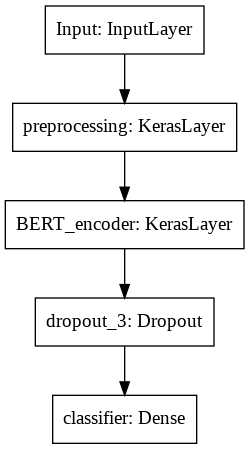

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
# convert data to tf.data.Dataset: https://www.tensorflow.org/tutorials/load_data/pandas_dataframe
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

for feat, targ in dataset.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: b'A suicide bomber says to his apprentice: "Watch carefully I can only do this once!"', Target: 1
Features: b"The problem with being gay It's a pain in the ass", Target: 1
Features: b"Don't let others be in charge of your mood.", Target: 0
Features: b"ME: Wow, that documentary about WW2 was really intense. I'd like to watch more like that. NETFLIX ALGORITHM: May I suggest That 70's Show?", Target: 1
Features: b'"Stress can result in more headaches as a result of the body rerouting blood flow to other parts of the body"', Target: 0


In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=dataset,
                               validation_data=val_dataset,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5


ValueError: ignored

# Humor Controversy

In [ ]:
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.metrics import roc_auc_score, f1_score

## Complement Naive Bayes

In [ ]:
cnb = ComplementNB(alpha=0.13).fit(count_vec_train, y_train)

print(f"AUC: {roc_auc_score(y_test, cnb.predict_proba(count_vec_test)[:, 1])}")
print(f"Accuracy: {cnb.score(count_vec_test, y_test)}")
print(f"F1 score: {f1_score(y_test, cnb.predict(count_vec_test))}")

AUC: 0.5051611358445687
Accuracy: 0.519059205190592
F1 score: 0.5143325143325143


In [ ]:
# creating submission

submission = pd.DataFrame({'id': test.id, 'humor_controversy': [int(x) for x in cnb.predict(count_vec_test.toarray())]})
submission.to_csv('satya_humor_controversy_cnb.csv', index = False)
submission.head()

,id,humor_controversy
0,9001,0
1,9002,0
2,9003,1
3,9004,0
4,9005,0


## Multinomial Naive Bayes

In [ ]:
mnb = MultinomialNB(alpha=0.1).fit(count_vec_train, y_train)

print(f"AUC: {roc_auc_score(y_test, mnb.predict_proba(count_vec_test)[:, 1])}")
print(f"Accuracy: {mnb.score(count_vec_test, y_test)}")
print(f"F1 score: {f1_score(y_test, mnb.predict(count_vec_test))}")

AUC: 0.50393104101544
Accuracy: 0.5182481751824818
F1 score: 0.5123152709359606


In [ ]:
# creating submission
submission['humor_controversy'] = [int(x) for x in mnb.predict(count_vec_test.toarray())]
submission.to_csv('satya_humor_controversy.csv', index = False)
submission.head()

,id,is_humor,humor_controversy
0,9001,0,0
1,9002,0,0
2,9003,1,1
3,9004,1,0
4,9005,1,0


# Offense Rating

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error

## Linear Regression

In [ ]:
lr = LinearRegression().fit(count_vec_train.toarray(), y_train)

print(f"RMSE: {mean_squared_error(y_test, lr.predict(count_vec_test.toarray()), squared=False)}")

RMSE: 5980576324.777095


## Ridge

Ridge without CV: 0.8128699661948782, 0.7301772046509064

In [ ]:
ridge = RidgeCV().fit(count_vec_train.toarray(), y_train)

print(f"RMSE: {mean_squared_error(y_test, ridge.predict(count_vec_test.toarray()), squared=False)}")

RMSE: 0.7652841129209773


In [ ]:
ridge = RidgeCV().fit(tfidf_vec_train.toarray(), y_train)

print(f"RMSE: {mean_squared_error(y_test, ridge.predict(tfidf_vec_test.toarray()), squared=False)}")

RMSE: 0.7301772046509092


## Lasso

Lasso without CV: 0.9881738007350648

In [ ]:
lasso = LassoCV(random_state=42).fit(count_vec_train.toarray(), y_train)

print(f"RMSE: {mean_squared_error(y_test, lasso.predict(count_vec_test.toarray()), squared=False)}")

RMSE: 0.7712570083715173


In [ ]:
lasso = LassoCV(random_state=42).fit(tfidf_vec_train.toarray(), y_train)

print(f"RMSE: {mean_squared_error(y_test, lasso.predict(tfidf_vec_test.toarray()), squared=False)}")

RMSE: 0.7263111881004822


## Elastic Net

ElasticNet without CV: 0.9881738007350648

In [ ]:
en = ElasticNetCV(random_state=42).fit(count_vec_train.toarray(), y_train)

print(f"RMSE: {mean_squared_error(y_test, en.predict(count_vec_test.toarray()), squared=False)}")

RMSE: 0.7659854709707241


In [ ]:
en = ElasticNetCV(random_state=42).fit(tfidf_vec_train.toarray(), y_train)

print(f"RMSE: {mean_squared_error(y_test, en.predict(tfidf_vec_test.toarray()), squared=False)}")

RMSE: 0.7154388967193742


## Decision Tree

In [ ]:
dtree = DecisionTreeRegressor(random_state=42).fit(count_vec_train.toarray(), y_train)

print(f"RMSE: {mean_squared_error(y_test, dtree.predict(count_vec_test.toarray()), squared=False)}")

RMSE: 0.9464170372163285


## XGBoost

In [ ]:
xgboost = xgb.XGBRegressor(random_state=42).fit(count_vec_train.toarray(), y_train)

print(f"RMSE: {mean_squared_error(y_test, xgboost.predict(count_vec_test.toarray()), squared=False)}")

[02:20:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.8016733891734107
